# Information Retrieval 1/2

Dans cette session, nous allons explorer plusieurs méthodes d'Information Retrieval (IR). L'objectif est de comprendre les intérêts et limites de différentes méthodes.

Ces méthodes permettent de sélectionner les passages de texte les plus pertinents à envoyer au modèle génératif. C'est donc une étape essentielle du développement d'un système de RAG, pour permettre de générer une réponse appropriée.

Il faudra ensuite séléctionner les meilleures méthodes à intégrer à l'outil de RAG.

## Load text chunks

In [ ]:
# Passages textuels test

text_chunks = ["""New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy, according to the 2000 census. See also Italians in New York City for more info.""",
                """Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza.""",
                """The Italian wolf is the national animal of Italy,[159] while the national tree is the strawberry tree.[160] The reasons for this are that the Italian wolf, which inhabits the Apennine Mountains and the Western Alps, features prominently in Latin and Italian cultures, such as the legend of the founding of Rome,[161] while the green leaves, white flowers and red berries of the strawberry tree, native to the Mediterranean, recall the colours of the flag.[160]""",
                """Italian cuisine has a great variety of different ingredients which are commonly used, ranging from fruits and vegetables to grains to cheeses, meats, and fish. In northern Italy, fish (such as cod, or baccalà), potatoes, rice, corn (maize), sausages, pork, and different types of cheese are the most common ingredients.""",
                """A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight. No italian food today, left feeling hungry and deceived, wishing the beautiful garden center had actually been the restaurant of his dreams.""",
               """New York City : A brand new italian restaurant, Italian #1, just opened in little Italy."""
                ]

query = "Do you know any italian restaurant in New York?"

## Utilisation d'embeddings

Une méthode d'IR classique consiste à calculer une représentation vectorielle (embedding) de chaque passage et de la question requête.

Les passages sont donc classés en fonction d'un score de similarité entre leur représentation et celle de la requête.

In [ ]:
# Liste des passages

res_scores = [{'text':text_chunks[i]} for i in range(len(text_chunks))]

res_scores

[{'text': 'New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy, according to the 2000 census. See also Italians in New York City for more info.'},
 {'text': 'Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza.'},
 {'text': 'The Italian wolf is the national animal of Italy,[159] while the national tree is the strawberry tree.[160] The reasons for this are that the Italian wolf, which inhabits the Apennine Mountains and the Western Alps, features prominently in Latin and Italian cultures, such as the legend of the founding of Rome,[161] while the green leaves, white flowers and red berries of the strawberry tree, native to the Mediterranean, recall the colours of the flag.[160]'},
 {'text': 'Italian cuisine has a great variety of different ingredients which are commonly used, ranging from fruits and vegetables to grains to cheeses, meats, and fish. In no

## Bag Of Words embeddings

### Questions




*   Quel est le principe d'un modèle Bag Of Words (BOW)?

Le principe du modèle Bag Of Words (BOW) repose sur la représentation textuelle en tant que vecteur de termes (mots) sans tenir compte de l'ordre dans lequel ils apparaissent :

**Principe du modèle Bag Of Words (BOW)**


1.   Représentation Vectorielle

Chaque document ou passage de texte est représenté comme un vecteur de mots (ou "termes").
Chaque mot unique dans le corpus (ensemble de documents) constitue une dimension dans cet espace vectoriel.
2.   Ignore l'Ordre des Mots

Le modèle BOW ne tient pas compte de l'ordre des mots. Il se concentre uniquement sur la présence ou l'absence de mots, ou sur leur fréquence.
3.   Vecteur de Fréquence des Mots

La valeur de chaque dimension dans le vecteur représente la fréquence d'apparition du mot correspondant dans le document.
Par exemple, si le corpus contient les mots "chien", "chat", et "souris", un document contenant "chien chien chat" serait représenté par le vecteur [2, 1, 0].
4.   Étapes pour Construire un Modèle BOW

Tokenization : Diviser le texte en mots individuels.

Construction du Vocabulaire : Créer une liste de tous les mots uniques dans le corpus.

Encodage des Documents : Compter le nombre d'occurrences de chaque mot du vocabulaire dans chaque document et construire les vecteurs correspondants.

### Text preprocessing

In [ ]:
!pip install nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Fonction pour appliquer un traitement sur le texte
# Facultatif

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(input_text):
    # Convertir en minuscules
    output_text = input_text.lower()

    # Supprimer les caractères spéciaux
    output_text = re.sub(r'[^A-Za-z0-9\s]', '', output_text)

    # Tokenization (division du texte en mots)
    words = word_tokenize(output_text)

    # Supprimer les stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization (réduction des mots à leur forme de base)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Rejoindre les mots en une seule chaîne de caractères
    output_text = ' '.join(words)

    return output_text

# Exemple d'utilisation
example_text = "Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza."
processed_text = preprocess_text(example_text)
print(processed_text)


graziano perhaps best place nyc eat quality fresh pasta enjoy neapolitanstyle pizza


### TF

Une première méthode consiste à calculer la fréquence de chaque mot dans les passages. On s'appuie aussi sur un vocabulaire, qui peut classiquement être composé de tous les mots des passages.

Un passage est alors représenté par un vecteur de la taille du vocabulaire, où la ième valeur compte le nombre d'occurence du ième mot du vocabulaire dans le passage.

On peut par exemple utiliser l'objet CountVectorizer de la bibliothèque scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Cet objet peut déjà inclure un certain nombre de prétraitements, examinez la documentation pour déterminer l'utilisation optimale.

In [ ]:
!pip install scikit-learn nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Prétraiter les passages textuels et la requête
preprocessed_chunks = [preprocess_text(chunk) for chunk in text_chunks]
preprocessed_query = preprocess_text(query)

from sklearn.feature_extraction.text import CountVectorizer

# Charger un modèle de TF
counter = CountVectorizer()

# Ajuster le modèle et calculer les embeddings des passages
text_embeddings = counter.fit_transform(preprocessed_chunks)

# Calculer l'embedding de la requête avec le même modèle
query_embedding = counter.transform([preprocessed_query])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcule les scores TF
tf_scores = text_embeddings.dot(query_embedding.toarray().flatten())
res_scores = [{'text': text_chunks[i], 'tf_score': tf_scores[i]} for i in range(len(tf_scores))]

# Affiche les scores TF pour vérification
for i in range(len(tf_scores)):
    print(f"Passage {i+1} TF Score: {tf_scores[i]}")

Passage 1 TF Score: 6
Passage 2 TF Score: 0
Passage 3 TF Score: 3
Passage 4 TF Score: 1
Passage 5 TF Score: 7
Passage 6 TF Score: 6


In [ ]:
# Classe les passages selon le score TF

sorted(res_scores,key=lambda x: x['tf_score'],reverse=True)[:10]

[{'text': 'A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight. No italian food today, left feeling hungry and deceived, wishing the beautiful garden center had actually been the restaurant of his dreams.',
  'tf_score': 7},
 {'text': 'New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy, according to the 2000 census. See also Italians in New York City for more info.',
  'tf_score': 6},
 {'text': 'New York City : A brand new italian restaurant, Italian #1, just opened in little Italy.',
  'tf_score': 6},
 {'text': 'The Italian wolf is the national animal of Italy,[159] while the national tree is the strawberry tree.[160] The reasons for this are that the Italian wolf, which inhabits the Ap

### TFIDF

In [ ]:
# TODO : Calculer les embeddings avec la méthode TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Prétraiter les passages textuels et la requête
preprocessed_chunks = [preprocess_text(chunk) for chunk in text_chunks]
preprocessed_query = preprocess_text(query)

# Charger un modèle de TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Ajuster le modèle et calculer les embeddings des passages
tfidf_embeddings = tfidf_vectorizer.fit_transform(preprocessed_chunks)

# Calculer l'embedding de la requête avec le même modèle
query_tfidf_embedding = tfidf_vectorizer.transform([preprocessed_query])


In [ ]:
# TODO : Calcule les scores TF-IDF

# Calcul des scores TF-IDF
tfidf_scores = cosine_similarity(query_tfidf_embedding, tfidf_embeddings).flatten()
res_scores_tfidf = [{'text': text_chunks[i], 'tfidf_score': tfidf_scores[i]} for i in range(len(tfidf_scores))]

# Affiche les scores TF-IDF pour vérification
for i in range(len(tfidf_scores)):
    print(f"Passage {i+1} TF-IDF Score: {tfidf_scores[i]}")


Passage 1 TF-IDF Score: 0.34911507251484836
Passage 2 TF-IDF Score: 0.0
Passage 3 TF-IDF Score: 0.08496412995610152
Passage 4 TF-IDF Score: 0.03104922540437337
Passage 5 TF-IDF Score: 0.322512495425627
Passage 6 TF-IDF Score: 0.6879340158252472


In [ ]:
# TODO : Trier les phrases selon les scores TF-IDF et les afficher

# Trier les passages selon le score TF-IDF
sorted_res_scores_tfidf = sorted(res_scores_tfidf, key=lambda x: x['tfidf_score'], reverse=True)[:10]

# Afficher les passages classés selon les scores TF-IDF
for i, res in enumerate(sorted_res_scores_tfidf):
    print(f"Rank {i+1}:")
    print(f"Text: {res['text']}")
    print(f"TF-IDF Score: {res['tfidf_score']}\n")


Rank 1:
Text: New York City : A brand new italian restaurant, Italian #1, just opened in little Italy.
TF-IDF Score: 0.6879340158252472

Rank 2:
Text: New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy, according to the 2000 census. See also Italians in New York City for more info.
TF-IDF Score: 0.34911507251484836

Rank 3:
Text: A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight. No italian food today, left feeling hungry and deceived, wishing the beautiful garden center had actually been the restaurant of his dreams.
TF-IDF Score: 0.322512495425627

Rank 4:
Text: The Italian wolf is the national animal of Italy,[159] while the national tree is the strawberry tree.[160] The reasons for

## Questions



*   Quel est l'intérêt du modèle TF-IDF par rapport au calcul TF?
*   Quelles sont les limites fondamentales d'un modèle BOW
*   (Facultatif) Qu'est ce que la méthode BM25 et quel ajout propose-t-elle par rapport à une TF-IDF?





**1. Quel est l'intérêt du modèle TF-IDF par rapport au calcul TF ?**

Le modèle TF-IDF (Term Frequency-Inverse Document Frequency) offre plusieurs avantages par rapport au simple calcul TF (Term Frequency).



*   Pondération par fréquence inverse des documents :


Le TF-IDF prend en compte non seulement la fréquence d'un terme dans un document (TF), mais aussi l'importance de ce terme dans le corpus global. Il réduit l'importance des termes qui apparaissent fréquemment dans de nombreux documents, ce qui les rend moins discriminants.
Formule : TF-IDF(t, d) = TF(t, d) * IDF(t), où IDF(t) = log(N / DF(t)), N étant le nombre total de documents et DF(t) le nombre de documents contenant le terme t.

*   Réduction de la dominance des mots courants :

Les mots courants (comme "le", "et", "la" en français) apparaissent fréquemment dans les documents et peuvent dominer le score TF s'ils ne sont pas pondérés. TF-IDF atténue cette influence en réduisant leur poids.
Cela aide à mettre en évidence les termes plus rares et plus informatifs dans chaque document.

*   Amélioration de la pertinence :

En pondérant les termes en fonction de leur fréquence inverse dans les documents, TF-IDF améliore la pertinence des résultats de recherche en favorisant les termes qui sont significatifs pour un document particulier mais rares dans le corpus global.




**2. Quelles sont les limites fondamentales d'un modèle BOW ?**

Le modèle Bag of Words (BOW) a plusieurs limitations fondamentales :

*   Ignorance de l'ordre des mots :

BOW ne tient pas compte de l'ordre des mots dans les documents. Par conséquent, il ne capture pas les relations syntaxiques ou contextuelles entre les mots, ce qui peut entraîner une perte d'information cruciale pour l'analyse du texte.

*   Perte de contexte :

Le modèle BOW traite chaque mot de manière indépendante, ce qui signifie qu'il ne prend pas en compte le contexte dans lequel un mot apparaît. Cela peut mener à des problèmes d'ambiguïté et à une compréhension limitée du sens des mots.

*   Vocabulaire fixe :

BOW nécessite un vocabulaire fixe pour tous les documents du corpus. Cela peut poser des problèmes lorsque de nouveaux mots apparaissent dans les documents futurs qui n'étaient pas présents dans le vocabulaire initial.

*   Sparsité :

Les vecteurs BOW peuvent devenir très longs et sparsés, surtout pour les grands corpus avec un vocabulaire étendu. Cela peut entraîner des inefficacités en termes de stockage et de calcul.

*   Pas de pondération des termes :

BOW ne pondère pas les termes en fonction de leur importance. Tous les termes sont traités de manière égale, ce qui peut donner un poids excessif aux mots courants et non informatifs.

**3. (Facultatif) Qu'est-ce que la méthode BM25 et quel ajout propose-t-elle par rapport à une TF-IDF ?**

La méthode BM25 (Best Matching 25) est une fonction de score de pertinence utilisée pour la recherche d'information et le classement des documents. Elle est basée sur le modèle de récupération probabiliste et améliore les concepts de TF-IDF.

Ajouts et avantages de BM25 par rapport à TF-IDF :

* Pondération non linéaire de la fréquence des termes :

BM25 introduit une pondération non linéaire de la fréquence des termes, ce qui signifie que l'augmentation de la fréquence d'un terme dans un document a un effet décroissant sur le score de pertinence. Cela permet d'éviter la surpondération des termes très fréquents.

* Longueur de document normalisée :

BM25 normalise la longueur des documents, ce qui signifie qu'il prend en compte la longueur des documents pour ajuster le score de pertinence. Les documents plus longs ne sont pas pénalisés de manière excessive, et les documents plus courts ne sont pas avantagés de manière injuste.

* Paramètres ajustables :

BM25 inclut des paramètres ajustables tels que k1 (paramètre de saturation de fréquence des termes) et b (paramètre de normalisation de la longueur du document). Ces paramètres permettent d'affiner le modèle pour mieux correspondre aux caractéristiques spécifiques du corpus et des requêtes.

* Formule de BM25 :
La formule de BM25 pour calculer le score de pertinence d'un document D pour une requête Q est :

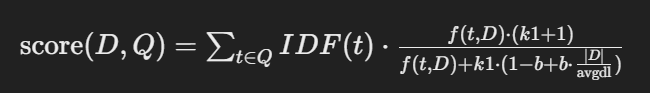


f(t, D) : fréquence du terme t dans le document D
|D| : longueur du document D (nombre de termes)
avgdl : longueur moyenne des documents dans le corpus
k1 et b : paramètres de réglage
IDF(t) : inverse document frequency du terme t


En résumé, BM25 améliore la méthode TF-IDF en introduisant une pondération non linéaire de la fréquence des termes, en normalisant la longueur des documents et en permettant l'ajustement des paramètres pour mieux adapter le modèle aux besoins spécifiques.


## Dense Embedding

Des modèles plus complexes permettent de créer des embeddings plus efficaces. Beaucoup de modèles existent, et différents leaderboards permettent de les comparer. Par exemple, le leaderboard MTEB de HuggingFace liste de nombreux modèles (https://huggingface.co/spaces/mteb/leaderboard).
L'utilisation est ensuite similaire aux modèles BOW étudiés dans la partie précédente.

### Embedding from HuggingFace

## Questions

*   En observant le leaderboard d'huggingface pour les modèles d'embedding (https://huggingface.co/spaces/mteb/leaderboard), quelles sont les modèles qui semblent les plus pertinents?


*   Nous proposons par exemple d'utiliser le modèle *mxbai-embed-large-v1*. Quels sont les avantages de ce modèle?

**1) Les modèles les plus pertinents selon les critères de performance et de capacité**

* NV-Embed-v1 : Meilleur score global.
* voyage-large-2-instruct : Excellente performance en PairClassification et STS.
* Linq-Embed-Mistral : Très bonnes performances globales et capacité à gérer de longues séquences.
* SFR-Embedding-Mistral et gte-Qwen1.5-7B-instruct : Modèles puissants avec de grandes capacités de traitement.

Ces modèles sont tous adaptés à des tâches de traitement de texte variées et complexes, offrant un bon équilibre entre performance, capacité et flexibilité.


**2) Pertinence du modèle mxbai-embed-large-v1**

* Performance globale :

Le modèle a une performance moyenne de 64.68 sur 56 ensembles de données, indiquant une bonne capacité à généraliser sur diverses tâches.

* Spécialisation sur certaines tâches :

Excellente performance en PairClassification Average (87.2) et STS Average (85), suggérant une forte aptitude pour des tâches nécessitant une compréhension fine des relations entre les textes.
Bonne performance en Classification Average (75.64) et Reranking Average (60.11).

* Dimensions des embeddings :

Avec 1024 dimensions, le modèle peut capturer une grande quantité d'informations contextuelles.

* Utilisation de la mémoire et taille du modèle :

Une taille de modèle de 335 millions de paramètres et une utilisation de mémoire de 1.25 Go, ce qui est raisonnable pour les capacités d'un modèle large sans être excessivement gourmand en ressources.

* Capacité à traiter des séquences longues :

Peut gérer jusqu'à 512 tokens, ce qui est adéquat pour la plupart des tâches de traitement de texte.

* Conclusion

Le modèle mxbai-embed-large-v1 est pertinent car il offre un bon équilibre entre taille du modèle, capacité de mémoire, et dimensions des embeddings, tout en affichant des performances solides sur diverses tâches, notamment en classification de paires et similarité sémantique textuelle. Ces caractéristiques le rendent adapté à une large gamme d'applications NLP nécessitant des embeddings denses et riches en informations.

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from tqdm import tqdm

# Charger le modèle
model_name = 'BAAI/bge-reranker-large'  # Vous pouvez choisir un autre modèle si nécessaire
model = SentenceTransformer(model_name)

# Calculer les embeddings des passages
passage_embeddings = model.encode(text_chunks, convert_to_tensor=True, show_progress_bar=True)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when p

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at BAAI/bge-reranker-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Calculer l'embedding de la requête
query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=True)

# Calculer les scores
scores = cos_sim(query_embedding, passage_embeddings)[0]

# Ajouter les scores au dictionnaire des scores
res_scores = [{'text': text_chunks[i], 'similarity_score': scores[i].item()} for i in range(len(scores))]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# TODO : Trier les passages par score et les afficher

# Trier les passages par score et les afficher
sorted_res_scores = sorted(res_scores, key=lambda x: x['similarity_score'], reverse=True)[:10]

for i, res in enumerate(sorted_res_scores):
    print(f"Rank {i+1}:")
    print(f"Text: {res['text']}")
    print(f"Similarity Score: {res['similarity_score']}\n")

Rank 1:
Text: New York City : A brand new italian restaurant, Italian #1, just opened in little Italy.
Similarity Score: 0.9999665021896362

Rank 2:
Text: Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza.
Similarity Score: 0.9301338195800781

Rank 3:
Text: A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight. No italian food today, left feeling hungry and deceived, wishing the beautiful garden center had actually been the restaurant of his dreams.
Similarity Score: 0.9255460500717163

Rank 4:
Text: New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy, according to the 2000 census. See also Italians in New York City for more info.
Simila

## Modèle spécalisé

Au lieu de calculer un score de similarité sur des embeddings, on peut utiliser un modèle qui prend directement en entrée un passage et la requête et qui calcule un score. Il existe en effet des réseaux de neuronnes spécialisés dans cette tâche.

Vous pouvez par exemple utiliser le modèle 'BAAI/bge-reranker-large' : https://huggingface.co/BAAI/bge-reranker-large

In [ ]:
!pip install FlagEmbedding

!pip install transformers
!pip install torch


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Charger le tokenizer et le modèle
model_name = "BAAI/bge-reranker-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Exemple de passages textuels
text_chunks = [
    """New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy, according to the 2000 census. See also Italians in New York City for more info.""",
    """Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza.""",
    """The Italian wolf is the national animal of Italy,[159] while the national tree is the strawberry tree.[160] The reasons for this are that the Italian wolf, which inhabits the Apennine Mountains and the Western Alps, features prominently in Latin and Italian cultures, such as the legend of the founding of Rome,[161] while the green leaves, white flowers and red berries of the strawberry tree, native to the Mediterranean, recall the colours of the flag.[160]""",
    """Italian cuisine has a great variety of different ingredients which are commonly used, ranging from fruits and vegetables to grains to cheeses, meats, and fish. In northern Italy, fish (such as cod, or baccalà), potatoes, rice, corn (maize), sausages, pork, and different types of cheese are the most common ingredients.""",
    """A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight. No italian food today, left feeling hungry and deceived, wishing the beautiful garden center had actually been the restaurant of his dreams.""",
    """New York City : A brand new italian restaurant, Italian #1, just opened in little Italy."""
]

query = "Do you know any italian restaurant in New York?"

# Initialiser la liste des scores
res_scores = [{'text': chunk} for chunk in text_chunks]

# Calculer les scores et les ajouter au dictionnaire des scores
for i, passage in enumerate(text_chunks):
    inputs = tokenizer(query, passage, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        score = outputs.logits[0].item()  # Utiliser directement la valeur du logit
    res_scores[i]['rerank_score'] = score


In [ ]:
# Trier les phrases selon le score calculé et afficher les meilleurs passages
sorted_res_scores = sorted(res_scores, key=lambda x: x['rerank_score'], reverse=True)[:10]

for i, res in enumerate(sorted_res_scores):
    print(f"Rank {i+1}:")
    print(f"Text: {res['text']}")
    print(f"Rerank Score: {res['rerank_score']}\n")

Rank 1:
Text: New York City : A brand new italian restaurant, Italian #1, just opened in little Italy.
Rerank Score: 4.036306858062744

Rank 2:
Text: Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza.
Rerank Score: 3.6253268718719482

Rank 3:
Text: A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight. No italian food today, left feeling hungry and deceived, wishing the beautiful garden center had actually been the restaurant of his dreams.
Rerank Score: 0.7126434445381165

Rank 4:
Text: Italian cuisine has a great variety of different ingredients which are commonly used, ranging from fruits and vegetables to grains to cheeses, meats, and fish. In northern Italy, fish (such as cod, or baccalà), potatoes, rice, corn (ma

## Analyse des résultas

### Représenter sous la forme de bar plot les scores des extraits pour les deux méthodes (dense embedding + cosine similarity et modèle reranker)

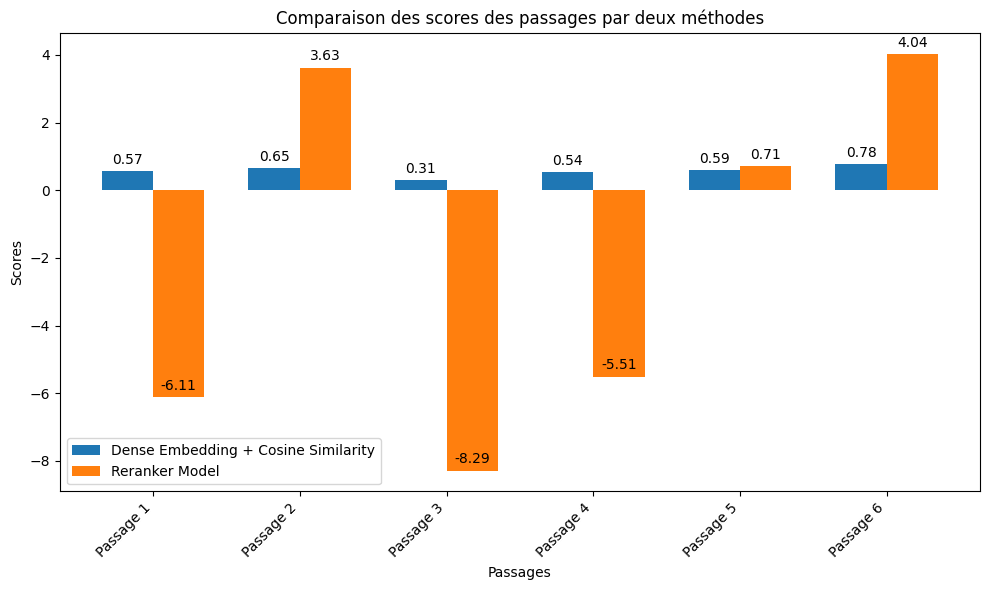

In [ ]:
### 1. Calcul des scores avec dense embedding + cosine similarity ###

from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import numpy as np

# Charger le modèle SentenceTransformer
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_model = SentenceTransformer(embedding_model_name)

# Calculer les embeddings des passages
passage_embeddings = embedding_model.encode(text_chunks, convert_to_tensor=True)

# Calculer l'embedding de la requête
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# Calculer les scores de similarité cosinus
cosine_scores = util.cos_sim(query_embedding, passage_embeddings)[0]

# Stocker les résultats
dense_scores = [{'text': text_chunks[i], 'cosine_score': cosine_scores[i].item()} for i in range(len(text_chunks))]


### 2. Calcul des scores avec le modèle reranker ###

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Charger le tokenizer et le modèle
reranker_model_name = "BAAI/bge-reranker-large"
tokenizer = AutoTokenizer.from_pretrained(reranker_model_name)
model = AutoModelForSequenceClassification.from_pretrained(reranker_model_name)

# Calculer les scores du reranker
reranker_scores = []
for i, passage in enumerate(text_chunks):
    inputs = tokenizer(query, passage, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        score = outputs.logits[0].item()
    reranker_scores.append({'text': passage, 'rerank_score': score})


### 3. Générer les bar plots ###

# Extraire les scores pour les deux méthodes
dense_scores_values = [item['cosine_score'] for item in dense_scores]
reranker_scores_values = [item['rerank_score'] for item in reranker_scores]

# Créer les labels pour les passages
labels = [f"Passage {i+1}" for i in range(len(text_chunks))]

# Configuration du bar plot
x = np.arange(len(labels))  # La position des labels sur l'axe des x
width = 0.35  # La largeur des barres

fig, ax = plt.subplots(figsize=(10, 6))

# Ajouter les barres pour les scores dense embedding + cosine similarity
rects1 = ax.bar(x - width/2, dense_scores_values, width, label='Dense Embedding + Cosine Similarity')

# Ajouter les barres pour les scores du modèle reranker
rects2 = ax.bar(x + width/2, reranker_scores_values, width, label='Reranker Model')

# Ajouter du texte pour les labels, titre et axes x et y
ax.set_xlabel('Passages')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des scores des passages par deux méthodes')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Ajouter les annotations sur les barres
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()






*   Quelle est la différence fondamentale dans l'utilisation, en pratique, des deux méthodes précédentes?
*   En examinant les deux modèles précédents, lequel devrait être en principe donner les meilleurs résultats et pourquoi?
*   Finalement, quels sont les intérêts d'avoir à disposition ces deux modèles et en quoi peuvent-ils être complémentaires?
*   Expliquez pourquoi le dernier modèle est appelé "reranker".


**1. Quelle est la différence fondamentale dans l'utilisation, en pratique, des deux méthodes précédentes?**

La différence fondamentale entre les deux méthodes est la manière dont elles calculent la similarité entre la requête et les passages :

* Dense Embedding + Cosine Similarity :

Cette méthode utilise un modèle de transformation de phrases (SentenceTransformer) pour convertir les textes en vecteurs d'embedding denses. Ensuite, la similarité cosinus est calculée entre les vecteurs de la requête et des passages. Cette méthode se base principalement sur les représentations vectorielles des textes et leur similarité géométrique dans l'espace vectoriel.

* Modèle Reranker :

Cette méthode utilise un modèle de reranking spécialisé (comme bge-reranker-large) qui est conçu pour évaluer la pertinence des passages par rapport à une requête spécifique. Le modèle prend en entrée la requête et chaque passage, puis prédit un score de pertinence. Ce modèle est souvent entraîné sur des données spécifiques de reranking et peut capturer des relations plus complexes entre la requête et les passages.

**2. En examinant les deux modèles précédents, lequel devrait être en principe donner les meilleurs résultats et pourquoi?**

En principe, le modèle reranker devrait donner les meilleurs résultats pour les tâches de recherche d'information spécifiques, car il est spécialement conçu et entraîné pour cette tâche. Les modèles reranker sont souvent entraînés sur des ensembles de données annotées où les passages pertinents sont explicitement marqués, ce qui leur permet de mieux comprendre et évaluer la pertinence des passages en contexte. Ils peuvent capturer des nuances plus fines et des relations complexes entre la requête et les passages, ce que la méthode de similarité cosinus pourrait manquer.

**3. Finalement, quels sont les intérêts d'avoir à disposition ces deux modèles et en quoi peuvent-ils être complémentaires?**


Avoir à disposition ces deux modèles offre plusieurs avantages :

* Complémentarité :

Les deux méthodes peuvent être utilisées de manière complémentaire. Par exemple, la méthode de similarité cosinus peut être utilisée pour un filtrage initial rapide des passages, suivie par le modèle reranker pour un affinage plus précis des résultats.

* Efficacité :

La méthode de similarité cosinus est généralement plus rapide et moins coûteuse en termes de calcul, ce qui la rend utile pour des tâches où la rapidité est essentielle.

* Robustesse :

Le modèle reranker peut offrir des résultats plus précis et pertinents, surtout dans des contextes où la précision est critique.

* Flexibilité :

La combinaison des deux méthodes permet de s'adapter à différents besoins et contraintes de performance, offrant une flexibilité accrue dans la mise en œuvre de systèmes de recherche d'information.


**4. Expliquez pourquoi le dernier modèle est appelé "reranker".**

Le modèle est appelé "reranker" parce qu'il est conçu pour reranker, ou réorganiser, une liste de passages en fonction de leur pertinence par rapport à une requête. Le processus de reranking implique généralement de prendre une liste initiale de résultats (par exemple, les passages les plus similaires trouvés par une méthode de recherche initiale) et de les réévaluer pour produire un ordre de pertinence plus précis. Le modèle reranker utilise des techniques avancées de traitement du langage naturel pour affiner et améliorer l'ordre des résultats, en mettant l'accent sur la qualité et la pertinence des passages par rapport à la requête utilisateur.

## Bonus

### BM25




*   BM25 est-elle une méthode sparse/BOW ou bien dense?

BM25 est une méthode sparse car les vecteurs générées sont souvent creux car se basent sur les représentations tf/idf.
*   Quels sont les avantages de BM25 par rapport à d'autres méthodes du même type?

BM25 a plusieurs avantages par rapoprt à d'autres méthodes: il s'adapte aux longueur des documents car il utilise la longueur moyenne de ces derniers, il est possible de gérer la saturation en jouant sur certains paramètres et plus généralement il est possible de jouer sur les différents paramètres pour adapter au mieux en fonction du contexte.
*   Implémenter l'algorithme BM25.



In [ ]:
import math

# prend une liste de documents et une query.
def bm25(documents, query, k1=1.5, b=0.75):
    # Calcul de la longueur moyenne des documents
    avgdl = sum(len(doc.split()) for doc in documents) / len(documents)
    # Initialisation des variables
    scores = {}
    query_words = query.split()
    doc_lengths = [len(doc.split()) for doc in documents]
    num_docs = len(documents)
    # Calcul de l'IDF pour chaque terme de la requête
    idf = {}
    for word in set(query_words):
        doc_freq = sum(1 for doc in documents if word in doc)
        idf[word] = math.log((num_docs - doc_freq + 0.5) / (doc_freq + 0.5) + 1)
    # Calcul des scores BM25 pour chaque document
    for i, doc in enumerate(documents):
        score = 0
        doc_words = doc.split()
        doc_len = doc_lengths[i]
        for word in query_words:
            tf = doc_words.count(word)
            score += idf.get(word, 0) * (tf * (k1 + 1) / (tf + k1 * (1 - b + b * (doc_len / avgdl))))
        scores[i] = score
    return scores



### word2vec


**1. Word2vec est-elle une méthode sparse/BOW ou bien dense?**

Word2vec est une méthode dense. Contrairement aux méthodes BOW qui créent des vecteurs de grande dimension mais sparse (avec beaucoup de zéros), word2vec génère des embeddings de faible dimension pour chaque mot dans un espace continu. Ces vecteurs denses capturent les relations sémantiques entre les mots.

**2. Quels sont les avantages de word2vec par rapport à d'autres méthodes du même type?**

Les avantages de word2vec par rapport à d'autres méthodes BOW sont les suivants :

* Capturer les relations sémantiques :

Word2vec est capable de capturer des relations sémantiques et syntaxiques entre les mots, ce qui permet de mieux comprendre le contexte dans lequel les mots sont utilisés.

* Dimensionnalité réduite :

Les vecteurs générés par word2vec sont denses et de faible dimension (typiquement 100 à 300 dimensions), ce qui réduit considérablement les besoins en stockage et en calcul par rapport aux représentations sparse de BOW.

* Généralisation :

Les embeddings de word2vec peuvent généraliser à des contextes et à des domaines différents, ce qui les rend utiles pour de nombreuses tâches de traitement du langage naturel.

* Efficacité :

 Word2vec peut être entraîné efficacement sur de grands corpus de texte, ce qui permet de créer des représentations de mots robustes et riches.

**3. Tester l'algorithme word2vec**


Nous allons utiliser la bibliothèque gensim pour tester l'algorithme word2vec sur un ensemble de textes d'exemple.

In [ ]:
!pip install gensim


In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

# Exemple de corpus de textes
corpus = [
    "New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy",
    "Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza",
    "The Italian wolf is the national animal of Italy, while the national tree is the strawberry tree",
    "Italian cuisine has a great variety of different ingredients which are commonly used, ranging from fruits and vegetables to grains to cheeses, meats, and fish",
    "A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight",
    "New York City : A brand new italian restaurant, Italian #1, just opened in little Italy"
]

# Préparer le corpus
sentences = [sentence.split() for sentence in corpus]

# Entraîner le modèle word2vec
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Tester le modèle
word = "italian"
if word in model.wv:
    similar_words = model.wv.most_similar(word)
    print(f"Mots les plus similaires à '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity}")
else:
    print(f"Le mot '{word}' n'est pas dans le vocabulaire du modèle.")

# Tester l'algorithme word2vec avec un autre exemple
word = "New"
if word in model.wv:
    similar_words = model.wv.most_similar(word)
    print(f"\nMots les plus similaires à '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity}")
else:
    print(f"Le mot '{word}' n'est pas dans le vocabulaire du modèle.")


Mots les plus similaires à 'italian':
outside: 0.26988741755485535
restaurant,: 0.15399420261383057
or: 0.14385786652565002
are: 0.13111288845539093
food: 0.12976358830928802
of: 0.1121378168463707
A: 0.11159130930900574
ingredients: 0.11008774489164352
animal: 0.10852344334125519
meats,: 0.10680308192968369

Mots les plus similaires à 'New':
has: 0.28524336218833923
different: 0.2399008721113205
fish: 0.21069680154323578
to: 0.1995134800672531
Graziano: 0.19042149186134338
ingredients: 0.17230916023254395
used,: 0.1682647317647934
place: 0.16737210750579834
actually: 0.15443946421146393
:: 0.15045520663261414


### BERT Encoder

**1. Utiliser un encodeur BERT correspond à une méthode sparse/BOW ou bien dense?**

Utiliser un encodeur BERT correspond à une méthode dense. BERT (Bidirectional Encoder Representations from Transformers) génère des représentations vectorielles denses pour les mots et les phrases, capturant les contextes bidirectionnels. Ces représentations denses sont de faible dimension comparées aux représentations sparse de BOW.


**2. Quels sont les avantages de BERT par rapport à d'autres méthodes du même type?**

Les avantages de BERT par rapport à d'autres méthodes du même type sont les suivants :

* Contextualisation bidirectionnelle :

BERT prend en compte le contexte à la fois à gauche et à droite d'un mot, contrairement à des modèles unidirectionnels qui ne considèrent que le contexte précédent.

* Capacité à capturer des relations complexes :

Grâce à son architecture transformer, BERT peut capturer des relations complexes et des dépendances à longue portée dans le texte.

* Fine-tuning pour des tâches spécifiques :

BERT peut être fine-tuné sur des tâches spécifiques (comme la classification, l'extraction d'informations, etc.), ce qui le rend très flexible et performant pour diverses applications NLP.

* Pré-entraînement sur de grands corpus :

BERT est pré-entraîné sur de vastes ensembles de données, ce qui lui permet d'apprendre des représentations linguistiques riches et de généraliser bien à différentes tâches et domaines.

**3. Tester le modèle BERT**

Nous allons utiliser transformers pour tester BERT sur un ensemble de textes d'exemple.


In [ ]:
!pip install transformers


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Charger le tokenizer et le modèle BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Exemple de corpus de textes
corpus = [
    "New York is known to be the largest Italian-American population in North America and third largest Italian population outside of Italy",
    "Graziano is perhaps the best place in NYC to eat quality fresh pasta, or enjoy a Neapolitan-style pizza",
    "The Italian wolf is the national animal of Italy, while the national tree is the strawberry tree",
    "Italian cuisine has a great variety of different ingredients which are commonly used, ranging from fruits and vegetables to grains to cheeses, meats, and fish",
    "A strange italian restaurant. After a long day at work in his New York City office, he wanted to enjoy delicious italian food at the newly opened La Casa di Pasta. But it was actually a nursery, specializing in Italian-themed plants and decorations, with no food in sight",
    "New York City : A brand new italian restaurant, Italian #1, just opened in little Italy"
]

# Encoder les phrases avec BERT
def encode_with_bert(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    # Utiliser la représentation [CLS] comme embedding de phrase
    sentence_embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return sentence_embeddings

# Calculer les embeddings des phrases
sentence_embeddings = encode_with_bert(corpus)

# Calculer les similarités cosinus entre les phrases
similarities = cosine_similarity(sentence_embeddings)

# Afficher les similarités cosinus
print("Similarités cosinus entre les phrases :")
print(similarities)

# Tester la similarité entre deux phrases spécifiques
query = "Do you know any italian restaurant in New York?"
query_embedding = encode_with_bert([query])[0]
similarities_to_query = cosine_similarity([query_embedding], sentence_embeddings)[0]

print("\nSimilarités cosinus entre la requête et les phrases du corpus :")
for i, similarity in enumerate(similarities_to_query):
    print(f"Phrase {i+1}: Similarité = {similarity:.4f}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Similarités cosinus entre les phrases :
[[0.99999976 0.77155125 0.7685242  0.77686703 0.7174585  0.7991778 ]
 [0.77155125 1.         0.71482384 0.7613641  0.83689445 0.83182627]
 [0.7685242  0.71482384 1.0000001  0.8087702  0.6979455  0.74634326]
 [0.77686703 0.7613641  0.8087702  1.0000001  0.7304798  0.7509769 ]
 [0.7174585  0.83689445 0.6979455  0.7304798  0.9999998  0.8160486 ]
 [0.7991778  0.83182627 0.74634326 0.7509769  0.8160486  1.        ]]

Similarités cosinus entre la requête et les phrases du corpus :
Phrase 1: Similarité = 0.7308
Phrase 2: Similarité = 0.8232
Phrase 3: Similarité = 0.6768
Phrase 4: Similarité = 0.7110
Phrase 5: Similarité = 0.8381
Phrase 6: Similarité = 0.8307
